<a href="https://colab.research.google.com/github/Thanwarin/robot-webots/blob/main/emotion_detection_FER_%2B_DeepFace_majorityvoting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y fer

Found existing installation: fer 22.4.0
Uninstalling fer-22.4.0:
  Successfully uninstalled fer-22.4.0


In [2]:
!pip install fer==22.4.0 opencv-python-headless matplotlib

  Using cached fer-22.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached fer-22.4.0-py3-none-any.whl (812 kB)


In [4]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 120.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires torch>=1.11.0, which is not installed.
fastai 2.8.5 requires torch<2.10,>=1.10, which is not installed.
torchvision 0.23.0+cu126 requires torch==2.8.0, which is not installed.
peft 0.17.1 requires torch>=1.13.0, which is not installed.
accel

Take snapshot 1/5


<IPython.core.display.Javascript object>

25-11-13 17:24:19 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 94.5MB/s]


FER: happy, DeepFace: Unknown, Final: happy
Take snapshot 2/5


<IPython.core.display.Javascript object>

FER: neutral, DeepFace: Unknown, Final: neutral
Take snapshot 3/5


<IPython.core.display.Javascript object>

FER: neutral, DeepFace: Unknown, Final: neutral
Take snapshot 4/5


<IPython.core.display.Javascript object>

FER: neutral, DeepFace: Unknown, Final: neutral
Take snapshot 5/5


<IPython.core.display.Javascript object>

FER: neutral, DeepFace: Unknown, Final: neutral


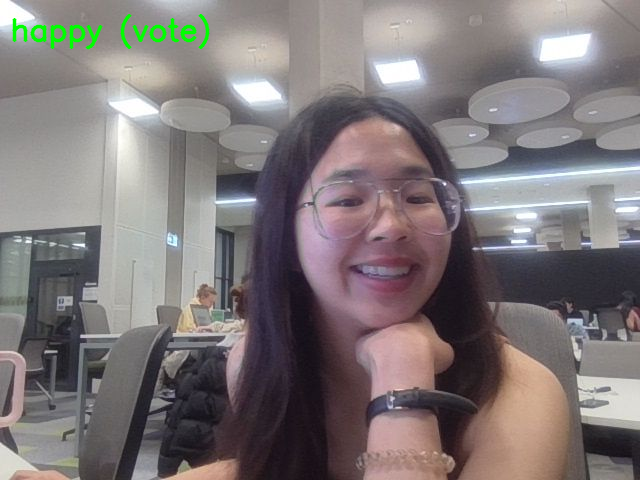

Snapshot 1: Emotion = happy


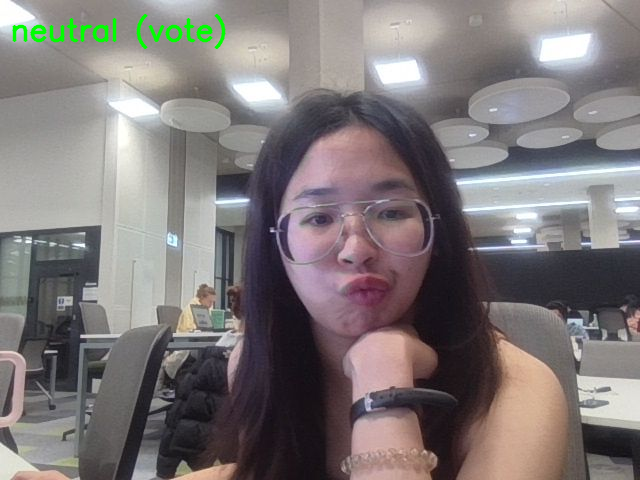

Snapshot 2: Emotion = neutral


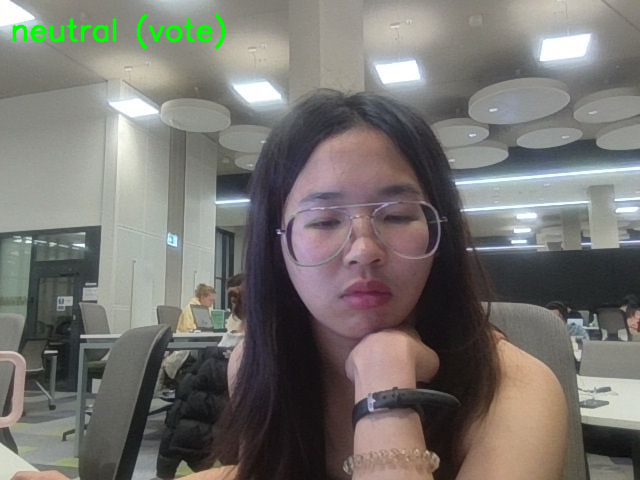

Snapshot 3: Emotion = neutral


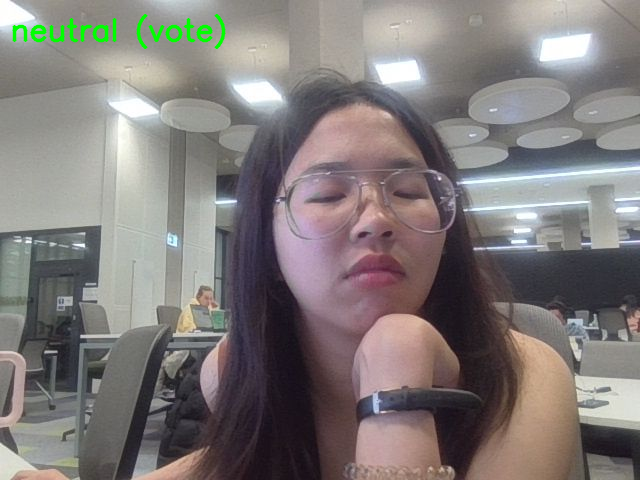

Snapshot 4: Emotion = neutral


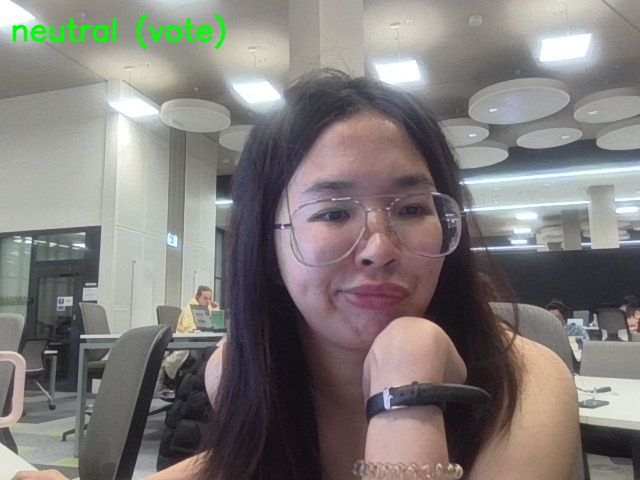

Snapshot 5: Emotion = neutral


In [3]:
from google.colab import output
from IPython.display import display, Javascript
import cv2
import numpy as np
from PIL import Image
import io
import base64
from fer import FER
from deepface import DeepFace
from collections import Counter
import time
from google.colab.patches import cv2_imshow  # ใช้แทน cv2.imshow

# Initialize FER
fer_detector = FER(mtcnn=True)

# ฟังก์ชันเปิด webcam และถ่าย snapshot
def take_photo(quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const button = document.createElement('button');
      button.textContent = 'Capture';
      div.appendChild(video);
      div.appendChild(button);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      await new Promise((resolve) => button.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = output.eval_js('takePhoto(%f)' % quality)
    content = data.split(',')[1]
    decoded = base64.b64decode(content)
    img = Image.open(io.BytesIO(decoded))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # Convert to BGR
    return img

# loop ถ่ายหลาย snapshots
frames = []
num_shots = 5
for i in range(num_shots):
    print(f"Take snapshot {i+1}/{num_shots}")
    img = take_photo()

    # Resize + convert BGR -> RGB
    img_resized = cv2.resize(img, (640, 480))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # 1️⃣ FER detect
    fer_result = fer_detector.top_emotion(img_resized)
    fer_emotion = fer_result[0] if fer_result[0] is not None else "Unknown"

    # 2️⃣ DeepFace detect
    try:
        deepface_result = DeepFace.analyze(
            img_rgb,
            actions=['emotion'],
            enforce_detection=False,
            detector_backend='mtcnn'
        )
        deepface_emotion = deepface_result['dominant_emotion']
    except:
        deepface_emotion = "Unknown"

    # 3️⃣ Majority voting
    emotions = [fer_emotion, deepface_emotion]
    counts = Counter(emotions)
    final_emotion = counts.most_common(1)[0][0]

    # Overlay final emotion บนภาพ
    cv2.putText(
        img_resized,
        f"{final_emotion} (vote)",
        (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
        cv2.LINE_AA
    )

    frames.append((img_resized, final_emotion))
    print(f"FER: {fer_emotion}, DeepFace: {deepface_emotion}, Final: {final_emotion}")
    time.sleep(1)

# แสดง snapshots + emotion
for idx, (img, emo) in enumerate(frames):
    cv2_imshow(img)
    print(f"Snapshot {idx+1}: Emotion = {emo}")
